### 제 2장 기본적인 추천 시스템

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
import pandas as pd
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users.set_index('user_id')
users.head()

,age,sex,occupation,zip_code
user_id,,,,
1,24,M,technician,85711
2,53,F,other,94043
3,23,M,writer,32067
4,24,M,technician,43537
5,33,F,other,15213


In [ ]:
# u.item 파일을 DataFrame으로 읽기
# 장르:unknown~Western (장르 동시에 체크 된 경우 존재.)
import pandas as pd
i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 
          'unknown', 'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 
          'Crime', 'Documentary', 'Drama', 'Fantasy', 'Film-Noir', 'Horror', 
          'Musical', 'Mystery', 'Romance', 'Sci-Fi', 'Thriller', 'War', 'Western']
movies = pd.read_csv('/u.item', sep='|', names=i_cols, encoding='latin-1')
movies = movies.set_index('movie_id')
movies.head()

,title,release date,video release date,IMDB URL,unknown,Action,Adventure,Animation,Children's,Comedy,Crime,Documentary,Drama,Fantasy,Film-Noir,Horror,Musical,Mystery,Romance,Sci-Fi,Thriller,War,Western
movie_id,,,,,,,,,,,,,,,,,,,,,,,
1,Toy Story (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Toy%20Story%2...,0,0,0,1,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0
2,GoldenEye (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?GoldenEye%20(...,0,1,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
3,Four Rooms (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Four%20Rooms%...,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0
4,Get Shorty (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Get%20Shorty%...,0,1,0,0,0,1,0,0,1,0,0,0,0,0,0,0,0,0,0
5,Copycat (1995),01-Jan-1995,NaN,http://us.imdb.com/M/title-exact?Copycat%20(1995),0,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,1,0,0


In [ ]:
# u.data 파일을 DataFrame으로 읽기
import pandas as pd
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/u.data', sep='\t', names=r_cols, encoding='latin-1') 
ratings = ratings.set_index('user_id')
ratings.head()

,movie_id,rating,timestamp
user_id,,,
196,242,3,881250949
186,302,3,891717742
22,377,1,878887116
244,51,2,880606923
166,346,1,886397596


In [ ]:
# Best-seller 추천 (가장 인기 있는 제품 추천)
def recom_movie1(n_items):
    movie_sort = movie_mean.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index]
    recommendations = recom_movies['title']
    return recommendations

# def recom_movie2(n_items): 위에 있는 함수와 동일.
# return movies.loc[movie_mean.sort_values(ascending=False)[:n_items].index]['title']

In [ ]:
# 평점의 평균값이 가장 높은 것을 순서대로 5개 추천.
movie_mean = ratings.groupby(['movie_id'])['rating'].mean()
recom_movie1(5)

movie_id
1293                                      Star Kid (1997)
1467                 Saint of Fort Washington, The (1993)
1653    Entertaining Angels: The Dorothy Day Story (1996)
814                         Great Day in Harlem, A (1994)
1122                       They Made Me a Criminal (1939)
Name: title, dtype: object

In [ ]:
# 정확도 계산 (정확도 지표 RMSE 선택.)
import numpy as np
def RMSE(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [ ]:
rmse = []
for user in set(ratings.index): # index로 지정했던 user_id 사용.
    y_true = ratings.loc[user]['rating']
    y_pred = movie_mean[ratings.loc[user]['movie_id']] # 평점평균: 예측값
    accuracy = RMSE(y_true, y_pred)
    rmse.append(accuracy) # 현재 사용자의 RMSE
print(np.mean(rmse)) # 전체 사용자의 RMSE의 평균

0.996007224010567


In [ ]:
# 사용자 집단별 추천
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/u.user', sep='|', names=u_cols, encoding='latin-1')

i_cols = ['movie_id', 'title', 'release date', 'video release date', 'IMDB URL', 'unknown', 
          'Action', 'Adventure', 'Animation', 'Children\'s', 'Comedy', 'Crime', 'Documentary', 
          'Drama', 'Fantasy', 'Film-Noir', 'Horror', 'Musical', 'Mystery', 'Romance', 'Sci-Fi', 
          'Thriller', 'War', 'Western']
movies = pd.read_csv('/u.item', sep='|', names=i_cols, encoding='latin-1')

r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/u.data', sep='\t', names=r_cols, encoding='latin-1')

In [ ]:
# timestamp 제거 
ratings = ratings.drop('timestamp', axis=1)

# movie ID와 title 빼고 다른 데이터 제거
movies = movies[['movie_id', 'title']]

In [ ]:
# train, test set 분리
from sklearn.model_selection import train_test_split
x = ratings.copy()
y = ratings['user_id'] # user_id별로 train_set, test_set 비율 동일하게 유지.
# len(ratings['user_id'].unique()): 943개 train, test set 분리
x_train, x_test, y_train, y_test = train_test_split(x, y, test_size=0.25, stratify=y)

In [ ]:
# 모델별 RMSE를 계산하는 함수 
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id']) # user, movie id pair 시킴.
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [ ]:
# train 데이터로 Full matrix 구하기 
# 평가하지 않은 조합은 NaN.
rating_matrix = x_train.pivot(index='user_id', columns='movie_id', values='rating')

In [ ]:
# 전체 평균으로 예측치를 계산하는 기본 모델
# try,except는 test data에만 있는 영화로 인해 발생하는 오류 방지
def best_seller(user_id, movie_id):
    try:
        rating = train_mean[movie_id]
    except:
        rating = 3.0
    return rating

train_mean = x_train.groupby(['movie_id'])['rating'].mean()
score(best_seller)

1.0262391483556985

In [ ]:
# 성별 기준 집단 생성 후 예측값 계산. (공통키인 user_id 기준)

merged_ratings = pd.merge(x_train, users)
users = users.set_index('user_id')

# gender별 평점평균 계산
g_mean = merged_ratings[['movie_id', 'sex', 'rating']].groupby(['movie_id', 'sex'])['rating'].mean()

In [ ]:
# gender별 평균을 예측치로 돌려주는 함수 
def cf_gender(user_id, movie_id):
    if movie_id in rating_matrix:
        gender = users.loc[user_id]['sex']
        if gender in g_mean[movie_id]: # 성별이 치우쳐져 rating 되어있을 수 있음.
            gender_rating = g_mean[movie_id][gender]
        else:
            gender_rating = 3.0
    else:
        gender_rating = 3.0
    return gender_rating

score(cf_gender) # 성별에 따른 추천이 정확도 개선하지 못한다.(오히려 떨어짐)

1.0368477869381156

### 제 3장 협업 필터링 추천 시스템

: 인구통계적 변수를 기준으로 나누지 않고, 취향을 기준으로 나눌 것.

: 취향이 비슷한 사람들의 집단(neighbor)이 존재한다고 가정. 각 사용자의 평가의 유사성(simliarity) 계산.

#### 유사도 지표

(1) 상관계수

(2) 코사인 유사도: 아이템(차원), 사용자의 평가값(좌표값)

-> 두 사용자의 평가값이 유사할수록 각도가 작다.

(3) 타니모토 계수: binary data

In [ ]:
# train set의 모든 가능한 사용자 pair의 Cosine similarities 계산

from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0) # NA->0
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy) # 대칭 matrix
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
# index 지정

In [ ]:
# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 사용자와 다른 사용자 간의 유사도(user_similarity)
def CF_simple(user_id, movie_id):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()
        # 현재 영화를 평가하지 않은 사용자의 index 가져오기 (가중평균 계산에서 빼기 위해)
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        # 현재 영화를 평가하지 않은 사용자의 rating (null) 제거
        movie_ratings = movie_ratings.dropna()
        # 현재 영화를 평가하지 않은 사용자의 similarity값 제거
        sim_scores = sim_scores.drop(none_rating_idx)
        # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
        mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산 (성별, 직업별 평균보다 개선됨)
score(CF_simple)

1.0208231645078234

#### 이웃을 고려한 CF

-> 이웃의 크기 줄이기

-> K-nearest negihbors/Thresholding (이웃의 기준 변경)

In [ ]:
# 모델별 RMSE를 계산하는 함수 
def score(model, neighbor_size=0):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie, neighbor_size) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [ ]:
# Neighbor size를 정해서 예측치를 계산하는 함수 
def cf_knn(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_matrix:
        sim_scores = user_similarity[user_id].copy()
        movie_ratings = rating_matrix[movie_id].copy()
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)

##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:          
            # 현재 영화를 평가한 모든 사용자의 가중평균값 구하기
            mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()

##### (3) Neighbor size가 지정된 경우
        else:                       
            # 해당 영화를 평가한 사용자가 최소 2명이 되는 경우에만 계산
            if len(sim_scores) > 1: 
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                # 유사도를 순서대로 정렬
                user_idx = np.argsort(sim_scores)
                # 가장 유사도가 높은 k명의 사용자 선정.
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                mean_rating = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            else:
                mean_rating = 3.0
    else:
        mean_rating = 3.0
    return mean_rating

# 정확도 계산 (이웃의 크기 고려하니 약간 개선됨.)
score(cf_knn, neighbor_size=30)

1.0119463875917478

#### 주어진 사용자에 대한 추천받기.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
# 실제 추천을 할 때에는 train, test set 나눌 필요 없음.
rating_matrix = ratings.pivot_table(values='rating', index='user_id', columns='movie_id')
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

In [ ]:
def recom_movie(user_id, n_items, neighbor_size=30):
    # 현 사용자가 평가한 평점 데이터만 가져오기
    user_movie = rating_matrix.loc[user_id].copy()
    for movie in rating_matrix:
        # 현 사용자가 이미 평가한 영화는 제외 (평점을 0으로)        
        if pd.notnull(user_movie.loc[movie]):
            user_movie.loc[movie] = 0
        else:
            user_movie.loc[movie] = cf_knn(user_id, movie, neighbor_size)

    # 영화를 예상 평점에 따라 정렬해서 제목을 뽑아서 돌려 줌
    movie_sort = user_movie.sort_values(ascending=False)[:n_items]
    recom_movies = movies.loc[movie_sort.index] # 영화 정보 추출
    recommendations = recom_movies['title']
    return recommendations

In [ ]:
recom_movie(user_id=2, n_items=5, neighbor_size=30)

movie_id
1293                     Ayn Rand: A Sense of Life (1997)
1189                              That Old Feeling (1997)
1467                                     Cure, The (1995)
1500    Prisoner of the Mountains (Kavkazsky Plennik) ...
318                       Everyone Says I Love You (1996)
Name: title, dtype: object

#### 최적의 neighbor size 구하기

In [ ]:
# train set으로 full matrix와 cosine similarity 구하기 
rating_matrix = x_train.pivot_table(values='rating', index='user_id', columns='movie_id')
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)
for neighbor_size in [10, 20, 30, 40, 50, 60]:
    print("Neighbor size = %d : RMSE = %.4f" % (neighbor_size, score(cf_knn, neighbor_size)))

 # neighbor size가 30 정도에서 최소가 된다.
 # 그 후, 더 세밀하게 1단위로 변화시키면서 결과를 보면 된다.   

Neighbor size = 10 : RMSE = 1.0300
Neighbor size = 20 : RMSE = 1.0144
Neighbor size = 30 : RMSE = 1.0119
Neighbor size = 40 : RMSE = 1.0121
Neighbor size = 50 : RMSE = 1.0130
Neighbor size = 60 : RMSE = 1.0136


#### 사용자의 평가경향(user bias)을 고려한 CF

In [ ]:
# train 데이터의 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T

In [ ]:
def CF_knn_bias(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id].copy()
        # 현 movie의 평점편차 가져오기
        movie_ratings = rating_bias[movie_id].copy()
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)
##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction = prediction + rating_mean[user_id]
##### (3) Neighbor size가 지정된 경우            
        else:           
            if len(sim_scores) > 1:
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                # 편차로 예측치 계산(예측치를 평점편차로 구함)
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                # 예측값에 현 사용자의 평균 더하기
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

In [ ]:
score(CF_knn_bias, 30) # 평가 경향 고려했더니 개선됨.

0.9441961190466248

#### 신뢰도 가중

: 공통으로 평가한 아이템의 수가 일정값 이상인 사용자만 이웃 사용자로 활용.

In [ ]:
# 공통으로 평가한 아이템의 수 계산

rating_binary1 = np.array((rating_matrix > 0).astype(float)) # 평점이 있는 경우만 1
rating_binary2 = rating_binary1.T
counts = np.dot(rating_binary1, rating_binary2)
# 행렬의 각 원소는 각각의 사용자가 공통으로 평가한 영화의 수
# digonal은 각 사용자가 평가한 영화의 수
counts = pd.DataFrame(counts, index=rating_matrix.index, columns=rating_matrix.index).fillna(0)

In [ ]:
def CF_knn_bias_sig(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id]
        movie_ratings = rating_bias[movie_id]
        # 현 movie에 대한 rating이 없는 사용자 표시
        no_rating = movie_ratings.isnull()
        # 현 사용자와 다른 사용자간 공통 평가 아이템 수 가져오기 
        common_counts = counts[user_id]
        # 공통으로 평가한 영화의 수가 SIG_LEVEL보다 낮은 사용자 표시
        low_significance = common_counts < SIG_LEVEL
        # 평가를 안 하였거나, SIG_LEVEL이 기준 이하인 user 제거
        none_rating_idx = movie_ratings[no_rating | low_significance].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)
##### (2) Neighbor size가 지정되지 않은 경우        
        if neighbor_size == 0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction = prediction + rating_mean[user_id]
##### (3) Neighbor size가 지정된 경우            
        else:
            # 해당 영화를 평가한 사용자가 최소 MIN_RATINGS 이상인 경우에만 계산            
            if len(sim_scores) > MIN_RATINGS:
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

SIG_LEVEL = 3 #최소 신뢰도(공통 평가 영화 수)
MIN_RATINGS = 2 #최소 사용자 수(현재 영화를 평가한 사용자 수)

In [ ]:
score(CF_knn_bias_sig, 30) #이웃의 수 30

0.943348411794892

#### Item-Based CF

: 예측 대상 사용자가 평가한 아이템의 평점과 다른 각 아이템과의 유사도를 가중해서 평균한 값을 그 아이템에 대한 예측값으로 사용.

In [ ]:
from sklearn.metrics.pairwise import cosine_similarity
rating_matrix_t = np.transpose(rating_matrix)
matrix_dummy = rating_matrix_t.copy().fillna(0)
item_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
item_similarity = pd.DataFrame(item_similarity, index=rating_matrix_t.index, columns=rating_matrix_t.index)

In [ ]:
# 주어진 영화의 (movie_id) 가중평균 rating을 계산하는 함수, 
# 가중치는 주어진 아이템과 다른 아이템 간의 유사도(item_similarity)

def CF_IBCF(user_id, movie_id):
    if movie_id in item_similarity:      # 현재 영화가 train set에 있는지 확인
        # 현재 영화와 다른 영화의 similarity 값 가져오기
        sim_scores = item_similarity[movie_id]
        # 현 사용자의 모든 rating 값 가져오기
        user_rating = rating_matrix_t[user_id]
        # 사용자가 평가하지 않은 영화 index 가져오기
        non_rating_idx = user_rating[user_rating.isnull()].index
        # 사용자가 평가하지 않은 영화 제거
        user_rating = user_rating.dropna()
        # 사용자가 평가하지 않은 영화의 similarity 값 제거
        sim_scores = sim_scores.drop(non_rating_idx)
        # 현 영화에 대한 예상 rating 계산, 가중치는 현 영화와 사용자가 평가한 영화의 유사도
        mean_rating = np.dot(sim_scores, user_rating) / sim_scores.sum()
    else:
        mean_rating = 3.0
    return mean_rating

In [ ]:
def score(model):
    id_pairs = zip(x_test['user_id'], x_test['movie_id'])
    y_pred = np.array([model(user, movie) for (user, movie) in id_pairs])
    y_true = np.array(x_test['rating'])
    return RMSE(y_true, y_pred)

In [ ]:
score(CF_IBCF) #UBCF와 큰 차이는 없음.

1.0177868674759176

#### 추천 시스템의 성과측정지표

: binary data일 경우, 추천 아이템과 사용자가 실제 선택한 아이템을 비교하여야 한다.

=> precision(정밀도): 추천 시스템이 추천한 아이템 중 실제 사용자가 선택한 아이템의 비율

=> recall(재현율): 사용자가 실제로 선택한 전체 아이템 중에서 몇 개의 아이템을 올바르게 맞췄는가

### 제 4장 Matrix Factorization 기반 추천

모델 기반 알고리즘: 데이터로부터 추천을 위한 모델을 구성한 후에 이 모델만 저장하고, 실제 추천을 할 때에는 이 모델을 사용해서 추천을 하는 방식. 약한 신호도 더 잘 잡아낸다.

#### MF 방식의 원리

MF(행렬 요인화): 평가 데이터 (사용자X아이템으로 구성된) 하나의 행렬을 2개의 행렬(사용자 행렬(P), 아이템 행렬(Q))로 분해하는 방법

P,Q 행렬에서 공통인 K개의 요인(잠재요인)

=> 잠재요인을 보면 어떤 영화가 어떤 사용자 취향에 맞을지 예상할 수 있음.

#### SGD(stochastic gradient decent)를 사용한 MF 알고리즘

In [ ]:
# MF class
class MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K # 잠재요인의 수
        self.alpha = alpha # 학습률
        self.beta = beta # 정규화 계수
        self.iterations = iterations # sgd 계산을 할 때의 반복 횟수
        self.verbose = verbose # sgd 중간 학습과정 출력 여부

    # Root Mean Squared Error (RMSE) 계산
    def rmse(self):
        xs, ys = self.R.nonzero() # R에서 평점이 있는 요소의 인덱스 가져옴.
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2)) # error 사용하여 RMSE 계산

    def train(self): # 정해진 횟수 만큼 P,Q,bu,bd값 업데이트

        # 평균 0, 표준편차:1/k인 정규분포 난수로 초기화
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))

        # bu,bd 초기화 + 전체평균 b 저장
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # R 중 평점이 있는 요소의 인덱스 가져옴.
        rows, columns = self.R.nonzero()
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # SGD 개선 기록, 10회 반복마다 중간 결과 표시
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse = self.rmse()
            training_process.append((i+1, rmse))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f " % (i+1, rmse))
        return training_process

    # 평점 예측값 구하는 함수.
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction

    # SGD 실행 함수
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

In [ ]:
# 전체 데이터 사용 MF
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
train_process = mf.train()

Iteration: 10 ; Train RMSE = 0.9585 
Iteration: 20 ; Train RMSE = 0.9373 
Iteration: 30 ; Train RMSE = 0.9280 
Iteration: 40 ; Train RMSE = 0.9225 
Iteration: 50 ; Train RMSE = 0.9184 
Iteration: 60 ; Train RMSE = 0.9145 
Iteration: 70 ; Train RMSE = 0.9099 
Iteration: 80 ; Train RMSE = 0.9036 
Iteration: 90 ; Train RMSE = 0.8947 
Iteration: 100 ; Train RMSE = 0.8826 


#### train,test 분리 MF 알고리즘

In [ ]:
from sklearn.utils import shuffle
TRAIN_SIZE = 0.75
ratings = shuffle(ratings, random_state=1)
cutoff = int(TRAIN_SIZE * len(ratings)) # 전체 데이터 중 Train set의 데이터 개수
ratings_train = ratings.iloc[:cutoff]
ratings_test = ratings.iloc[cutoff:]

In [ ]:
# New MF class for training & testing
# 사용자 아이디(user_id)와 아이템 아이디(item_id)를 인덱스와 맵핑한다.

class NEW_MF():
    def __init__(self, ratings, K, alpha, beta, iterations, verbose=True):
        self.R = np.array(ratings)
##### >>>>> (2) user_id, item_id를 R의 index와 매핑하기 위한 dictionary 생성
        item_id_index = []
        index_item_id = []
        for i, one_id in enumerate(ratings):
            item_id_index.append([one_id, i])
            index_item_id.append([i, one_id])
        self.item_id_index = dict(item_id_index)
        self.index_item_id = dict(index_item_id)

        user_id_index = []
        index_user_id = []
        for i, one_id in enumerate(ratings.T):
            user_id_index.append([one_id, i])
            index_user_id.append([i, one_id])
        self.user_id_index = dict(user_id_index)
        self.index_user_id = dict(index_user_id)

#### <<<<< (2)
        self.num_users, self.num_items = np.shape(self.R)
        self.K = K
        self.alpha = alpha
        self.beta = beta
        self.iterations = iterations
        self.verbose = verbose
    # train set의 RMSE 계산
    def rmse(self):
        xs, ys = self.R.nonzero()
        self.predictions = []
        self.errors = []
        for x, y in zip(xs, ys):
            prediction = self.get_prediction(x, y)
            self.predictions.append(prediction)
            self.errors.append(self.R[x, y] - prediction)
        self.predictions = np.array(self.predictions)
        self.errors = np.array(self.errors)
        return np.sqrt(np.mean(self.errors**2))
    # Ratings for user i and item j
    def get_prediction(self, i, j):
        prediction = self.b + self.b_u[i] + self.b_d[j] + self.P[i, :].dot(self.Q[j, :].T)
        return prediction
    # Stochastic gradient descent to get optimized P and Q matrix
    def sgd(self):
        for i, j, r in self.samples:
            prediction = self.get_prediction(i, j)
            e = (r - prediction)
            self.b_u[i] += self.alpha * (e - self.beta * self.b_u[i])
            self.b_d[j] += self.alpha * (e - self.beta * self.b_d[j])
            self.P[i, :] += self.alpha * (e * self.Q[j, :] - self.beta * self.P[i,:])
            self.Q[j, :] += self.alpha * (e * self.P[i, :] - self.beta * self.Q[j,:])

##### >>>>> (3)
    # Test set을 선정
    def set_test(self, ratings_test):
        test_set = []
        for i in range(len(ratings_test)):      # test 데이터에 있는 각 데이터에 대해서
            x = self.user_id_index[ratings_test.iloc[i, 0]]
            y = self.item_id_index[ratings_test.iloc[i, 1]]
            z = ratings_test.iloc[i, 2] # 현재 사용자-아이템의 평점
            test_set.append([x, y, z])
            self.R[x, y] = 0                    # Setting test set ratings to 0
        self.test_set = test_set
        return test_set                       

    # Test set의 RMSE 계산
    def test_rmse(self):
        error = 0
        for one_set in self.test_set:
            predicted = self.get_prediction(one_set[0], one_set[1])
            error += pow(one_set[2] - predicted, 2)
        return np.sqrt(error/len(self.test_set))

    # Training 하면서 test set의 정확도를 계산
    def test(self):
        self.P = np.random.normal(scale=1./self.K, size=(self.num_users, self.K))
        self.Q = np.random.normal(scale=1./self.K, size=(self.num_items, self.K))
        self.b_u = np.zeros(self.num_users)
        self.b_d = np.zeros(self.num_items)
        self.b = np.mean(self.R[self.R.nonzero()])

        # List of training samples
        rows, columns = self.R.nonzero() #train set에서 test set에 해당하는 부분은 0으로 바꾸었기 때문에, R 전체가 train set이 된다.
        self.samples = [(i, j, self.R[i,j]) for i, j in zip(rows, columns)]

        # SGD
        training_process = []
        for i in range(self.iterations):
            np.random.shuffle(self.samples)
            self.sgd()
            rmse1 = self.rmse() # train set의 RMSE
            rmse2 = self.test_rmse() # test set의 RMSE
            training_process.append((i+1, rmse1, rmse2))
            if self.verbose:
                if (i+1) % 10 == 0:
                    print("Iteration: %d ; Train RMSE = %.4f ; Test RMSE = %.4f" % (i+1, rmse1, rmse2))
        return training_process

    # Ratings for given user_id and item_id
    def get_one_prediction(self, user_id, item_id):
        return self.get_prediction(self.user_id_index[user_id], self.item_id_index[item_id])

    # Full user-movie rating matrix
    def full_prediction(self):
        return self.b + self.b_u[:,np.newaxis] + self.b_d[np.newaxis,:] + self.P.dot(self.Q.T)

In [ ]:
R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
mf = NEW_MF(R_temp, K=30, alpha=0.001, beta=0.02, iterations=100, verbose=True)
test_set = mf.set_test(ratings_test)
result = mf.test()

Iteration: 10 ; Train RMSE = 0.9659 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9410 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9298 ; Test RMSE = 0.9567
Iteration: 40 ; Train RMSE = 0.9231 ; Test RMSE = 0.9524
Iteration: 50 ; Train RMSE = 0.9184 ; Test RMSE = 0.9497
Iteration: 60 ; Train RMSE = 0.9145 ; Test RMSE = 0.9479
Iteration: 70 ; Train RMSE = 0.9109 ; Test RMSE = 0.9464
Iteration: 80 ; Train RMSE = 0.9069 ; Test RMSE = 0.9451
Iteration: 90 ; Train RMSE = 0.9020 ; Test RMSE = 0.9436
Iteration: 100 ; Train RMSE = 0.8957 ; Test RMSE = 0.9418


In [ ]:
print(mf.full_prediction())
print(mf.get_one_prediction(1, 2)) # user_id가 1인 사용자의 item_id 2번 아이템에 대한 예측치

[[3.83831727 3.42728376 3.06180202 ... 3.34209285 3.47416976 3.46382333]
 [3.91471585 3.49663837 3.14996475 ... 3.43267438 3.54809987 3.54228495]
 [3.28950795 2.89736005 2.53706809 ... 2.81544201 2.93304898 2.93332613]
 ...
 [4.20962379 3.79153408 3.43862173 ... 3.72131153 3.83076693 3.81890373]
 [4.3242727  3.89567571 3.56321549 ... 3.82291673 3.93934757 3.93963273]
 [3.73904627 3.3600233  2.99424802 ... 3.3024826  3.44593186 3.41606257]]
3.427283757709133


#### MF의 최적 파라미터 찾기

In [ ]:
# 최적의 K값 찾기
results = []
index = []
for K in range(200, 211, 10): # 시간 많이 걸려서 200,210만 했어요
    print('K =', K)
    R_temp = ratings.pivot(index='user_id', columns='movie_id', values='rating').fillna(0)
    mf = NEW_MF(R_temp, K=K, alpha=0.001, beta=0.02, iterations=30, verbose=True)
    test_set = mf.set_test(ratings_test) # 앞에서 분리한 test set 지정.
    result = mf.test()
    index.append(K)
    results.append(result)

K = 200
Iteration: 10 ; Train RMSE = 0.9664 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9420 ; Test RMSE = 0.9644
Iteration: 30 ; Train RMSE = 0.9313 ; Test RMSE = 0.9566
K = 210
Iteration: 10 ; Train RMSE = 0.9664 ; Test RMSE = 0.9834
Iteration: 20 ; Train RMSE = 0.9420 ; Test RMSE = 0.9645
Iteration: 30 ; Train RMSE = 0.9313 ; Test RMSE = 0.9566


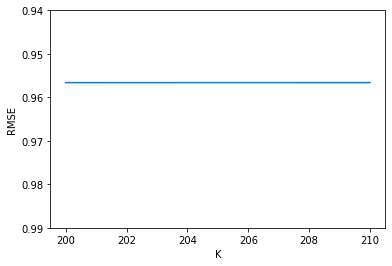

In [ ]:
# 최적의 iterations 값 찾기
summary = []
for i in range(len(results)):
    RMSE = []
    for result in results[i]:
        RMSE.append(result[2])
    min = np.min(RMSE)
    j = RMSE.index(min)
    summary.append([index[i], j+1, RMSE[j]])

# 그래프 그리기
import matplotlib.pyplot as plt
plt.plot(index, [x[2] for x in summary])
plt.ylim(0.99, 0.94)
plt.xlabel('K')
plt.ylabel('RMSE')
plt.show() # K=200을 최적의 K로 볼 것.

### 제 5장 Surprise 패키지 사용

In [ ]:
! pip install scikit-surprise

     |████████████████████████████████| 11.8MB 5.8MB/s 
  Created wheel for scikit-surprise: filename=scikit_surprise-1.1.1-cp37-cp37m-linux_x86_64.whl size=1617541 sha256=ad9dd6dc9d48caeaadba53f68d790cc968abe227453c353d2c670d255fd813f7
  Stored in directory: /root/.cache/pip/wheels/78/9c/3d/41b419c9d2aff5b6e2b4c0fc8d25c538202834058f9ed110d0
Successfully built scikit-surprise


In [ ]:
from surprise import BaselineOnly
from surprise import KNNWithMeans
from surprise import SVD
from surprise import SVDpp
from surprise import Dataset
from surprise import accuracy
from surprise import Reader
from surprise.model_selection import cross_validate
from surprise.model_selection import train_test_split

In [ ]:
data = Dataset.load_builtin('ml-100k')
trainset, testset = train_test_split(data, test_size=0.25)

algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Dataset ml-100k could not be found. Do you want to download it? [Y/n] Y
Trying to download dataset from http://files.grouplens.org/datasets/movielens/ml-100k.zip...
Done! Dataset ml-100k has been saved to /root/.surprise_data/ml-100k
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9540


0.9540080061420287

Estimating biases using als...
RMSE: 0.9467
Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9540
RMSE: 0.9417
RMSE: 0.9230


array([0.92300196, 0.94174704, 0.94669289, 0.95400801])

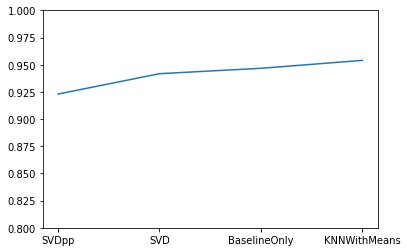

In [ ]:
# 알고리즘 비교
algorithms = [BaselineOnly, KNNWithMeans, SVD, SVDpp] # 여기서는 SVDpp가 가장 정확.
names = []
results = []
for option in algorithms:
    algo = option()
    names.append(option.__name__)       # 알고리즘 이름 
    algo.fit(trainset)
    predictions = algo.test(testset)
    results.append(accuracy.rmse(predictions))
names = np.array(names)
results = np.array(results)

# 결과를 그래프로 표시
import matplotlib.pyplot as plt
index = np.argsort(results) #정확도 순서대로 정렬한 인덱스 받아온다
plt.ylim(0.8, 1)
plt.plot(names[index], results[index])
results[index]

In [ ]:
# 알고리즘 옵션 변경, 정확도 계산
sim_options = {'name': 'pearson_baseline',
               'user_based': True}
algo = KNNWithMeans(k=30, sim_options=sim_options)

algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9422


0.942176868902798

In [ ]:
# 다양한 Neighbor size 비교, 여기서는 K=40일때 최선.
result = []
for neighbor_size in (10, 20, 30, 40, 50, 60):
    algo = KNNWithMeans(k=neighbor_size, sim_options={'name':
           'pearson_baseline', 'user_based': True}) # UBCF사용, 유사도지표:pearson_baseline
    algo.fit(trainset)
    predictions = algo.test(testset)
    result.append([neighbor_size, accuracy.rmse(predictions)])
result

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9565
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9442
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9422
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9415
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9418
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
RMSE: 0.9422


[[10, 0.9565477041648505],
 [20, 0.9441555760179853],
 [30, 0.942176868902798],
 [40, 0.9415067906687419],
 [50, 0.9417847292665135],
 [60, 0.9422154447789063]]

In [ ]:
# KNN 다양한 파라메터 비교
from surprise.model_selection import GridSearchCV
param_grid = {'k': [5, 10, 15, 25],
              'sim_options': {'name': ['pearson_baseline', 'cosine'],
                              'user_based': [True, False]} # UBCF,IBCF 비교
              }
gs = GridSearchCV(KNNWithMeans, param_grid, measures=['rmse'], cv=4)
gs.fit(data)

# 최적 RMSE 출력
print(gs.best_score['rmse'])

# 최적 RMSE의 parameter
print(gs.best_params['rmse'])

Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Estimating biases using als...
Computing the pearson_baseline similarity matrix...
Done computing similarity matrix.
Computing the cosine similarity matrix...
Done computing similar

In [ ]:
# SVD 다양한 파라메터 비교
from surprise.model_selection import GridSearchCV
param_grid = {'n_epochs': [70, 80, 90],
              'lr_all': [0.005, 0.006, 0.007],
              'reg_all': [0.05, 0.07, 0.1]}
gs = GridSearchCV(SVD, param_grid, measures=['rmse'], cv=5,n_)
gs.fit(data) # 너무 오래걸려여,,,

# 최적 RMSE 출력
print(gs.best_score['rmse'])

# 최적 RMSE의 parameter
print(gs.best_params['rmse'])

KeyboardInterrupt: ignored

In [ ]:
from surprise.model_selection import GridSearchCV

ModuleNotFoundError: ignored

In [ ]:
# 외부 데이터 불러오기
r_cols = ['user_id', 'movie_id', 'rating', 'timestamp']
ratings = pd.read_csv('/u.data', names=r_cols,  sep='\t',encoding='latin-1')
reader = Reader(rating_scale=(1,5))
data = Dataset.load_from_df(ratings[['user_id', 'movie_id', # Surprise의 Dataset 클래스로 읽어오면 된다.
        'rating']], reader)

# Train/Test 분리 
trainset, testset = train_test_split(data, test_size=0.25)

# 정확도 계산 
algo = KNNWithMeans()
algo.fit(trainset)
predictions = algo.test(testset)
accuracy.rmse(predictions)

Computing the msd similarity matrix...
Done computing similarity matrix.
RMSE: 0.9541


0.954081617487824

### 제 6장 딥러닝을 사용한 추천 시스템

딥러닝: 다수의 은닉층을 가진 인공신경망을 적용하는 기법

#### Keras로 MF 구현하기

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers
from tensorflow.keras.models import Model
from tensorflow.keras.layers import Input, Embedding, Dot, Add, Flatten
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import SGD, Adamax

In [ ]:
# Variable 초기화 
K = 200                             # Latent factor 수 
mu = ratings_train.rating.mean()    # 전체 평균 
M = ratings.user_id.max() + 1       # Number of users
N = ratings.movie_id.max() + 1      # Number of movies

In [ ]:
# Defining RMSE measure
def RMSE(y_true, y_pred):
    return tf.sqrt(tf.reduce_mean(tf.square(y_true - y_pred)))

In [ ]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

In [ ]:
R = layers.dot([P_embedding, Q_embedding], axes=2)              
R = layers.add([R, user_bias, item_bias])
R = Flatten()(R) # 1차원의 배열로 변경.

In [ ]:
# Model setting
model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_2 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding (Embedding)           (None, 1, 200)       188800      input_1[0][0]                    
__________________________________________________________________________________________________
embedding_1 (Embedding)         (None, 1, 200)       336600      input_2[0][0]                    
______________________________________________________________________________________________

In [ ]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=60,
  batch_size=256,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/60
293/293 [==============================] - 4s 9ms/step - loss: 5.3943 - RMSE: 1.1230 - val_loss: 5.0346 - val_RMSE: 1.1239
Epoch 2/60
293/293 [==============================] - 2s 7ms/step - loss: 4.9210 - RMSE: 1.1221 - val_loss: 4.6003 - val_RMSE: 1.1221
Epoch 3/60
293/293 [==============================] - 2s 7ms/step - loss: 4.4962 - RMSE: 1.1174 - val_loss: 4.2141 - val_RMSE: 1.1204
Epoch 4/60
293/293 [==============================] - 2s 7ms/step - loss: 4.1247 - RMSE: 1.1193 - val_loss: 3.8706 - val_RMSE: 1.1188
Epoch 5/60
293/293 [==============================] - 2s 7ms/step - loss: 3.7931 - RMSE: 1.1198 - val_loss: 3.5652 - val_RMSE: 1.1173
Epoch 6/60
293/293 [==============================] - 2s 7ms/step - loss: 3.4935 - RMSE: 1.1154 - val_loss: 3.2936 - val_RMSE: 1.1159
Epoch 7/60
293/293 [==============================] - 2s 7ms/step - loss: 3.2276 - RMSE: 1.1121 - val_loss: 3.0520 - val_RMSE: 1.1147
Epoch 8/60
293/293 [==============================] - 2s 7ms/s

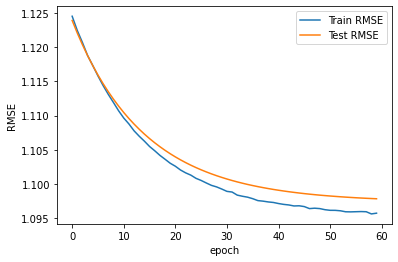

In [ ]:
# Plot RMSE
import matplotlib.pyplot as plt
plt.plot(result.history['RMSE'], label="Train RMSE")
plt.plot(result.history['val_RMSE'], label="Test RMSE")
plt.xlabel('epoch')
plt.ylabel('RMSE')
plt.legend()
plt.show()

In [ ]:
# Prediction
user_ids = ratings_test.user_id.values[0:3]
movie_ids = ratings_test.movie_id.values[0:3]
predictions = model.predict([user_ids, movie_ids]) + mu
print("Actuals: \n", ratings_test[0:6])
print( )
print("Predictions: \n", predictions)

Actuals: 
        user_id  movie_id  rating
53670      345       715       4
77110       92       998       2
69323      934       195       4
85968      586       423       2
30243      336       383       1
43868      654       678       4

Predictions: 
 [[3.5351827]
 [3.4959416]
 [3.5932786]]


In [ ]:
# RMSE check
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

user_ids = ratings_test.user_id.values
movie_ids = ratings_test.movie_id.values
y_pred = model.predict([user_ids, movie_ids]) + mu
y_pred = np.ravel(y_pred, order='C') # 1차원의 array로 바꿔준다.
y_true = np.array(ratings_test.rating)

RMSE2(y_true, y_pred)

1.0987217174031805

#### 딥러닝을 적용한 추천 시스템

In [ ]:
# Keras model
user = Input(shape=(1, ))                                               # User input
item = Input(shape=(1, ))                                               # Item input
P_embedding = Embedding(M, K, embeddings_regularizer=l2())(user)        # (M, 1, K)
Q_embedding = Embedding(N, K, embeddings_regularizer=l2())(item)        # (N, 1, K)
user_bias = Embedding(M, 1, embeddings_regularizer=l2())(user)          # User bias term (M, 1, )
item_bias = Embedding(N, 1, embeddings_regularizer=l2())(item)          # Item bias term (N, 1, )

In [ ]:
# Concatenate layers: 1차원으로 줄인다.
from tensorflow.keras.layers import Dense, Concatenate, Activation
P_embedding = Flatten()(P_embedding)                                    # (K, )
Q_embedding = Flatten()(Q_embedding)                                    # (K, )
user_bias = Flatten()(user_bias)                                        # (1, )
item_bias = Flatten()(item_bias)                                        # (1, )
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias])     # (2K + 2, )

In [ ]:
# Neural network
R = Dense(2048)(R)
R = Activation('linear')(R)
R = Dense(256)(R)
R = Activation('linear')(R)
R = Dense(1)(R)

model = Model(inputs=[user, item], outputs=R)
model.compile(
  loss=RMSE,
  optimizer=SGD(),
  #optimizer=Adamax(),
  metrics=[RMSE]
)
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_3 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
input_4 (InputLayer)            [(None, 1)]          0                                            
__________________________________________________________________________________________________
embedding_4 (Embedding)         (None, 1, 200)       188800      input_3[0][0]                    
__________________________________________________________________________________________________
embedding_5 (Embedding)         (None, 1, 200)       336600      input_4[0][0]                    
____________________________________________________________________________________________

In [ ]:
# Model fitting
result = model.fit(
  x=[ratings_train.user_id.values, ratings_train.movie_id.values],
  y=ratings_train.rating.values - mu,
  epochs=65,
  batch_size=512,
  validation_data=(
    [ratings_test.user_id.values, ratings_test.movie_id.values],
    ratings_test.rating.values - mu
  )
)

Epoch 1/65
147/147 [==============================] - 15s 97ms/step - loss: 5.4662 - RMSE: 1.1279 - val_loss: 5.2763 - val_RMSE: 1.1255
Epoch 2/65
147/147 [==============================] - 14s 95ms/step - loss: 5.2155 - RMSE: 1.1250 - val_loss: 5.0381 - val_RMSE: 1.1243
Epoch 3/65
147/147 [==============================] - 14s 96ms/step - loss: 4.9817 - RMSE: 1.1248 - val_loss: 4.8130 - val_RMSE: 1.1226
Epoch 4/65
147/147 [==============================] - 14s 96ms/step - loss: 4.7604 - RMSE: 1.1237 - val_loss: 4.6012 - val_RMSE: 1.1215
Epoch 5/65
147/147 [==============================] - 14s 95ms/step - loss: 4.5530 - RMSE: 1.1239 - val_loss: 4.4012 - val_RMSE: 1.1201
Epoch 6/65
147/147 [==============================] - 14s 95ms/step - loss: 4.3517 - RMSE: 1.1183 - val_loss: 4.2130 - val_RMSE: 1.1191
Epoch 7/65
147/147 [==============================] - 14s 96ms/step - loss: 4.1676 - RMSE: 1.1186 - val_loss: 4.0348 - val_RMSE: 1.1174
Epoch 8/65
147/147 [============================

#### 딥러닝 모델에 변수 추가하기

In [ ]:
u_cols = ['user_id', 'age', 'sex', 'occupation', 'zip_code']
users = pd.read_csv('/u.user', sep='|', names=u_cols, encoding='latin-1')
users = users[['user_id', 'occupation']]

In [ ]:
# Convert occupation(string to integer)
occupation = {}
def convert_occ(x):
    if x in occupation:
        return occupation[x]
    else:
        occupation[x] = len(occupation)
        return occupation[x]
users['occupation'] = users['occupation'].apply(convert_occ) 
# 사용자 데이터의 ocuupation 열을 int로 변환한다.

L = len(occupation)
train_occ = pd.merge(ratings_train, users, on='user_id')['occupation']
test_occ = pd.merge(ratings_test, users, on='user_id')['occupation']

In [ ]:
occ = Input(shape=(1, ))
occ_embedding = Embedding(L, 3, embeddings_regularizer=l2())(occ) # 3개의 잠재요인으로 embedding
occ_layer = Flatten()(occ_embedding)
R = Concatenate()([P_embedding, Q_embedding, user_bias, item_bias, occ_layer])

model = Model(inputs=[user, item, occ], outputs=R)

# RMSE가 눈에 띄게 향상되지는 않는다.
# 사용자의 평가 패턴과 상관관게가 있는 변수를 추가해야 RMSE가 향상된다.

### 제 7장 하이브리드 추천 시스템

: 복수의 추천 알고리즘을 결합해서 추천하는 것

In [ ]:
import random

In [ ]:
def RMSE2(y_true, y_pred):
    return np.sqrt(np.mean((np.array(y_true) - np.array(y_pred))**2))

In [ ]:
# Dummy recommender 0
def recommender0(recomm_list):
    recommendations = []
    for pair in recomm_list:
        recommendations.append(random.random() * 4 + 1)
    return np.array(recommendations)

# Dummy recommender 1
def recommender1(recomm_list):
    recommendations = []
    for pair in recomm_list:
        recommendations.append(random.random() * 4 + 1)
    return np.array(recommendations)

# Hybrid 결과 얻기
weight = [0.8, 0.2] # 두 추천엔진의 결합 비중
recomm_list = np.array(ratings_test)
predictions0 = recommender0(recomm_list)
predictions1 = recommender1(recomm_list)
predictions = predictions0 * weight[0] + predictions1 * weight[1] #가중 평균
RMSE2(recomm_list[:, 2], predictions)

1.5612758913754048

In [ ]:
##### CF 추천 알고리즘 >>>>>>>>>>>>>>>

rating_matrix = ratings_train.pivot(index='user_id', columns='movie_id', values='rating')

# train set 사용자들의 Cosine similarities 계산
from sklearn.metrics.pairwise import cosine_similarity
matrix_dummy = rating_matrix.copy().fillna(0)
user_similarity = cosine_similarity(matrix_dummy, matrix_dummy)
user_similarity = pd.DataFrame(user_similarity, index=rating_matrix.index, columns=rating_matrix.index)

# train 데이터의 user의 rating 평균과 영화의 평점편차 계산 
rating_mean = rating_matrix.mean(axis=1)
rating_bias = (rating_matrix.T - rating_mean).T

def CF_knn_bias(user_id, movie_id, neighbor_size=0):
    if movie_id in rating_bias:
        sim_scores = user_similarity[user_id]
        movie_ratings = rating_bias[movie_id]
        none_rating_idx = movie_ratings[movie_ratings.isnull()].index
        movie_ratings = movie_ratings.drop(none_rating_idx)
        sim_scores = sim_scores.drop(none_rating_idx)
        if neighbor_size == 0:
            prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
            prediction = prediction + rating_mean[user_id]
        else:
            if len(sim_scores) > 1:
                neighbor_size = min(neighbor_size, len(sim_scores))
                sim_scores = np.array(sim_scores)
                movie_ratings = np.array(movie_ratings)
                user_idx = np.argsort(sim_scores)
                sim_scores = sim_scores[user_idx][-neighbor_size:]
                movie_ratings = movie_ratings[user_idx][-neighbor_size:]
                prediction = np.dot(sim_scores, movie_ratings) / sim_scores.sum()
                prediction = prediction + rating_mean[user_id]
            else:
                prediction = rating_mean[user_id]
    else:
        prediction = rating_mean[user_id]
    return prediction

In [ ]:
##### Hybrid 추천 알고리즘

def recommender0(recomm_list, mf): # MF
    recommendations = np.array([mf.get_one_prediction(user, movie) for (user, movie) in recomm_list])
    return recommendations

def recommender1(recomm_list, neighbor_size=0): # CF
    recommendations = np.array([CF_knn_bias(user, movie, neighbor_size) for (user, movie) in recomm_list])
    return recommendations

recomm_list = np.array(ratings_test.iloc[:, [0, 1]])
predictions0 = recommender0(recomm_list, mf)
RMSE2(ratings_test.iloc[:, 2], predictions0)
predictions1 = recommender1(recomm_list, 37)
RMSE2(ratings_test.iloc[:, 2], predictions1)

weight = [0.8, 0.2]
predictions = predictions0 * weight[0] + predictions1 * weight[1] # 합친게 미세하게 더 좋게 나온다.
RMSE2(ratings_test.iloc[:, 2], predictions)


TypeError: ignored

In [ ]:
# 최적의 가중치 구하기. (0.88:0.12)
for i in np.arange(0, 1, 0.01):
    weight = [i, 1.0 - i]
    predictions = predictions0 * weight[0] + predictions1 * weight[1]
    print("Weights - %.2f : %.2f ; RMSE = %.7f" % (weight[0], 
           weight[1], RMSE2(ratings_test.iloc[:, 2], predictions)))